In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import scipy as sc
from scipy.linalg import expm

import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import time


from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix
from scripts_tempHelix import generate_static_temporal_helix, generate_static_temporal_helix2
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

# Experimental Hitting Time

In [17]:
def probability_distribution(M_t, init_state):
    """
    Computes the probability distribution p(t) for a graph with Laplacian matrix L,
    starting from the initial state init_state, at time t.
    """
    # Initial probability vector
    p0 = np.zeros(len(M_t))
    p0[init_state] = 1
    
    # Compute the transition matrix M(t)
    # M_t = transition_matrix(L, t)
    
    # Compute the new probability distribution p(t)
    p_t = np.round(np.dot(M_t, p0),5)
    
    return p_t

def efficient_transition_matrix(eigenvalues, eigenvectors, t):
    D_t = np.diag(np.exp(eigenvalues * t))
    return eigenvectors @ D_t @ np.linalg.inv(eigenvectors)

def first_passage_time(G, gamma, start, end, delta_t):
    """
    Simulates a continuous-time random walk on a graph G from start node to end node.
    It uses small time steps delta_t and probability distributions at each step to move to neighboring nodes.
    Returns the time taken to first reach the end node.
    """
    # Laplacian matrix of the graph
    # L = nx.laplacian_matrix(G).toarray() * gamma
    D = np.diag(list(dict(G.degree()).values()))
    A = nx.to_numpy_array(G)
    L = -gamma * (D - A)
    eigenvalues, eigenvectors = sc.linalg.eigh(L)
    p_t_list = []
    
    # Initialize variables
    current_state = start
    time_elapsed = delta_t
    
    # Run the walk until the end state is reached
    while current_state != end:
        # Calculate the probability distribution for a small time step delta_t
        M_t = efficient_transition_matrix(eigenvalues,eigenvectors,time_elapsed)
        # print(M_t.round(2))
        p_t = probability_distribution(M_t, current_state)
        p_t_list.append(p_t)
        
        # Extract the neighbors of the current state
        neighbors = list(G.neighbors(current_state)) + [current_state]

        # Get the transition probabilities for the neighbors
        transition_probabilities = p_t[neighbors]
        # print(transition_probabilities)
        
        # Normalize transition probabilities
        if np.sum(transition_probabilities) > 0:
            transition_probabilities /= np.sum(transition_probabilities)
        else:
        #     # Handle the special case where the sum is 0
        #     # For example, stay in the current state or choose randomly
            transition_probabilities = np.ones(len(neighbors)) / len(neighbors)
        # # print(transition_probabilities)
        # # print()
        # # print(p_t)
        next_state = np.random.choice(neighbors, p=transition_probabilities)
        # print(transition_probabilities)
        # print(neighbors)
        # print(next_state)
        
        # Update the current state and the time elapsed
        current_state = next_state
        time_elapsed += delta_t

    return time_elapsed


# n = 30
# G = nx.cycle_graph(n)


# # Set the transition rate gamma
# gamma = 1.0

# # Starting and ending vertices
# start_vertex = 0
# end_vertex = n//2
# delta_t = 0.01

# # Perform the walk and get the first-passage time
# time_taken,tot_prob_list = first_passage_time(G, gamma, start_vertex, end_vertex, delta_t)
# print(f"Time taken to reach node {end_vertex} from node {start_vertex}: {time_taken}")


## Calculating for a range of graphs

In [18]:
def average_hitting_time_for_range(n_range, samples, gamma, delta_t):
    """
    Calculates the average hitting time for graphs of sizes within n_range,
    performing a specified number of samples for each graph size.

    :param n_range: Range of graph sizes to test (e.g., range(5, 10))
    :param samples: Number of samples to perform for each graph size
    :param gamma: Transition rate parameter for the random walk
    :param delta_t: Time step for the random walk
    :return: List with average hitting times for each graph size
    """
    avg_hitting_times = []
    tot_prob_list_list = []

    for n in n_range:
        print(n)
        total_time = 0
        end_vertex = n // 2

        for _ in range(samples):
            G = nx.cycle_graph(n)
            start_vertex = 0

            time_taken = first_passage_time(G, gamma, start_vertex, end_vertex, delta_t)
            total_time += time_taken

        avg_hitting_times.append(total_time / samples)

    return avg_hitting_times



In [19]:
n_range = range(5, 100)
samples = 100
gamma = 1.0
delta_t = 0.01

# Start timing
start_time = time.time()

# Call the function
hitting_times_file = f'Datasets/HTStaticCycle/CTHittingTimeCycle_N{n_range[-1]}_FROM{0}-TO{49}_DeltaT{delta_t}_S{samples}.txt'
# hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    # fit_hitting_times = fit_hitting_time(sum_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = average_hitting_time_for_range(n_range, samples, gamma, delta_t)
    # fit_hitting_times = fit_hitting_time(sum_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Looking for: 
-----> Datasets/HTStaticCycle/CTHittingTimeCycle_N99_FROM0-TO49_DeltaT0.01_S100.txt

File exists!
Elapsed time: 0.016016721725463867 seconds


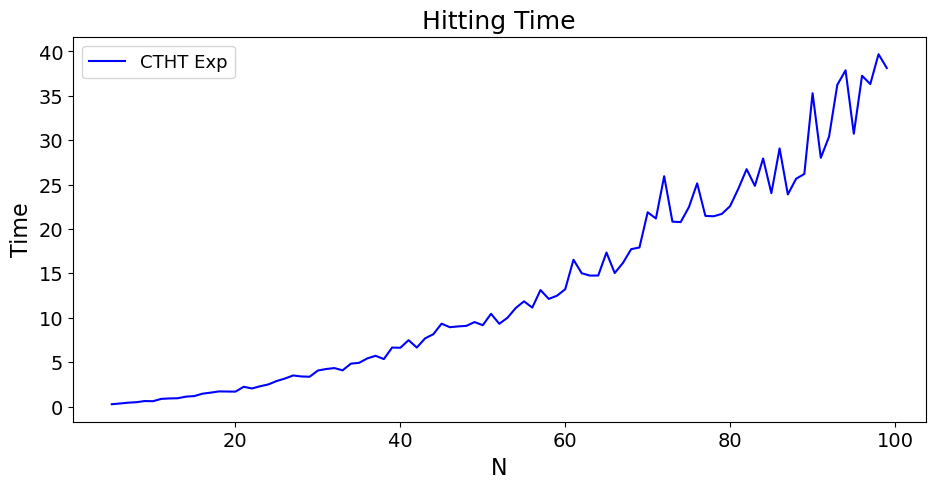

In [22]:
alphaLabelList = [r'CTHT Exp']# ,f'HT TheorV1 Szeg',f'HT TheorV4 Kr',f'HT TheorV5 Kr',f'n^2',f'{round(c,2)}n^{factor}']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Time",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}


# hitting_times = list(map(lambda x: x/0.1,hitting_times))
y_value_list = [[x for x in hitting_times]]

plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)

# Experimental Hitting Time v2

In [6]:
def efficient_transition_matrix(eigenvalues, eigenvectors, t):
    D_t = np.diag(np.exp(eigenvalues * t))
    return eigenvectors @ D_t @ np.linalg.inv(eigenvectors)


def probability_distribution(M_t, init_state):
    """
    Computes the probability distribution p(t) for a graph with Laplacian matrix L,
    starting from the initial state init_state, at time t.
    """
    # Initial probability vector
    p0 = np.zeros(len(M_t))
    p0[init_state] = 1
    
    # Compute the transition matrix M(t)
    # M_t = transition_matrix(L, t)
    
    # Compute the new probability distribution p(t)
    p_t = np.dot(M_t, p0).round(10)
    
    return p_t

def first_passage_time2(G, gamma, start, end, delta_t):
    """
    Simulates a continuous-time random walk on a graph G from start node to end node.
    It uses small time steps delta_t and probability distributions at each step to move to neighboring nodes.
    Returns the time taken to first reach the end node.
    """
    # Laplacian matrix of the graph
    D = np.diag(list(dict(G.degree()).values()))
    A = nx.to_numpy_array(G)
    L = -gamma * (D - A)
    eigenvalues, eigenvectors = sc.linalg.eigh(L)
    current_state = start
    
    M_t = efficient_transition_matrix(eigenvalues, eigenvectors, 0)
    p_t = probability_distribution(M_t, current_state)
    next_state = np.random.choice(range(len(p_t)), p=p_t)
    
    test = []

    # Initialize variables
    time_elapsed = delta_t
    
    # Run the walk until the end state is reached
    while current_state != end:
        # Calculate the probability distribution for a small time step delta_t
        M_t = efficient_transition_matrix(eigenvalues, eigenvectors, time_elapsed)
        p_t = probability_distribution(M_t, current_state)
        
        # Choose the next state randomly according to p_t
        # print(p_t)
        # print(np.sum(p_t))
        next_state = np.random.choice(range(len(p_t)), p=p_t)
        
        # Update the current state and the time elapsed
        current_state = next_state
        time_elapsed += delta_t

    return time_elapsed


n = 100
G = nx.cycle_graph(n)


# Set the transition rate gamma
gamma = 1.0

# Starting and ending vertices
start_vertex = 0
end_vertex = n//2
delta_t = 0.01

# Perform the walk and get the first-passage time
time_taken = first_passage_time2(G, gamma, start_vertex, end_vertex, delta_t)
print(f"Time taken to reach node {end_vertex} from node {start_vertex}: {time_taken}")

Time taken to reach node 50 from node 0: 3.049999999999979


## Calculating for a range of graphs

In [7]:
import time

def average_hitting_time_for_range2(n_range, samples, gamma, delta_t):
    """
    Calculates the average hitting time for graphs of sizes within n_range,
    performing a specified number of samples for each graph size.

    :param n_range: Range of graph sizes to test (e.g., range(5, 10))
    :param samples: Number of samples to perform for each graph size
    :param gamma: Transition rate parameter for the random walk
    :param delta_t: Time step for the random walk
    :return: List with average hitting times for each graph size
    """
    avg_hitting_times = []

    for n in n_range:
        print(n)
        total_time = 0
        end_vertex = n // 2

        for _ in range(samples):
            G = nx.cycle_graph(n)
            start_vertex = 0

            time_taken = first_passage_time2(G, gamma, start_vertex, end_vertex, delta_t)
            total_time += time_taken

        avg_hitting_times.append(total_time / samples)

    return avg_hitting_times



In [8]:
n_range = range(5, 30)
samples = 50
gamma = 1.0
delta_t = 0.01

# Start timing
start_time = time.time()

# Call the function
hitting_times_file = f'Datasets/HTStaticCycle/CTHittingTimeCycle2_N{n_range[-1]}_FROM{0}-TO{49}_DeltaT{delta_t}_S{samples}.txt'
# hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times2 = load_list_from_file(hitting_times_file)
    # fit_hitting_times = fit_hitting_time(sum_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times2 = average_hitting_time_for_range2(n_range, samples, gamma, delta_t)
    # fit_hitting_times = fit_hitting_time(sum_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times2)

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Looking for: 
-----> Datasets/HTStaticCycle/CTHittingTimeCycle2_N29_FROM0-TO49_DeltaT0.01_S50.txt

File exists!
Elapsed time: 0.013996124267578125 seconds


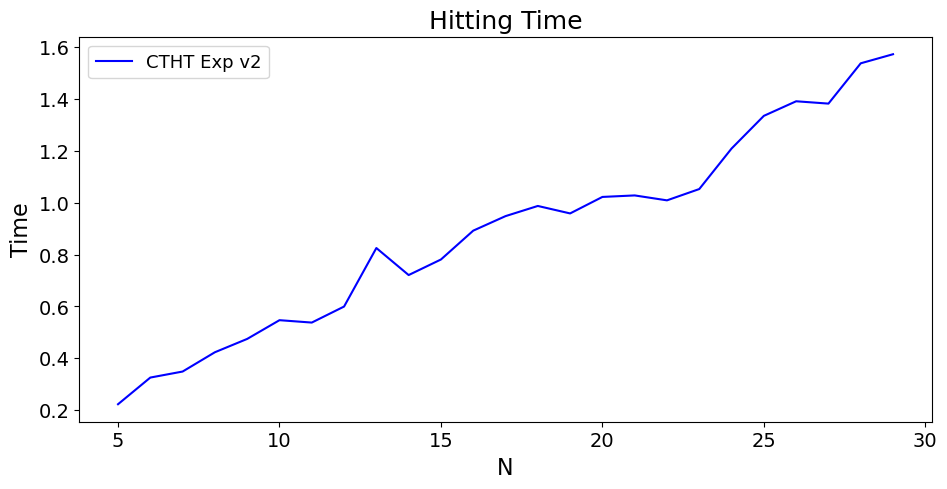

In [9]:
alphaLabelList = [r'CTHT Exp v2']# ,f'HT TheorV1 Szeg',f'HT TheorV4 Kr',f'HT TheorV5 Kr',f'n^2',f'{round(c,2)}n^{factor}']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Time",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}


# hitting_times = list(map(lambda x: x/0.1,hitting_times))
y_value_list = [hitting_times2]

plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)

# Theoretical Hitting Times

## $$
HT =\vec{e}_i\left(I-e^{-L \Delta t}\right)^{-1} 1_{uu}
$$

## First Version

In [47]:
def theoretical_hitting_time(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
        
    if target=='-1':
        target = n-1
        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def continuous_theoretical_hitting_times_for_cycle_graphs( graphList, gamma, delta_t, init):
    hitting_times = []
    for G in graphList:
            D = np.diag(list(dict(G.degree()).values()))
            A = nx.to_numpy_array(G)
            L = -gamma * (D - A)
            # print(f'm = {len(L)} \t trace = {np.trace(-L)})')
            P = expm(L * delta_t)
            target = 'mid'
            hitting_time = theoretical_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

n_range = range(5, 100)
gamma = 1.0
delta_t = 0.001
init = 0
graphList = [nx.cycle_graph(n) for n in n_range]
theor_time = continuous_theoretical_hitting_times_for_cycle_graphs(graphList, gamma, delta_t, init)


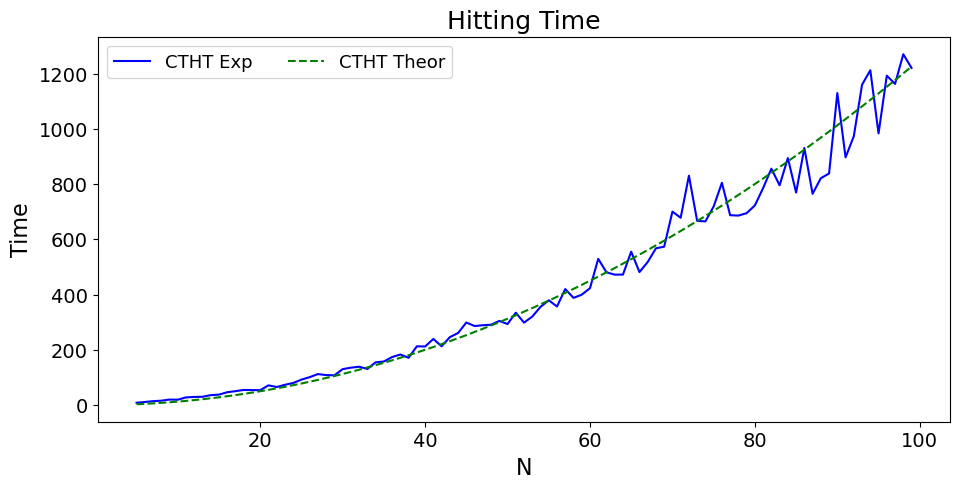

In [54]:
alphaLabelList = [r'CTHT Exp', r'CTHT Theor']# ,f'HT TheorV1 Szeg',f'HT TheorV4 Kr',f'HT TheorV5 Kr',f'n^2',f'{round(c,2)}n^{factor}']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Time",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}


# hitting_times = list(map(lambda x: x/0.1,hitting_times))
# print(hitting_times2*100)
# y_value_list = [[x*30000 for x in hitting_times],
#                theor_time]

y_value_list = [[x*32 for x in hitting_times],
                [x*delta_t for x in theor_time]]

plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)

## Second Version

In [8]:
n_range = range(5, 30)
gamma = 1.0
delta_t = 0.1
init = 0
graphList = [nx.cycle_graph(n) for n in n_range]
theor_time2 = continuous_theoretical_hitting_times_for_cycle_graphs(graphList, gamma, delta_t, init)


In [9]:
alphaLabelList = [r'CTHT Exp', r'CTHT Theor']# ,f'HT TheorV1 Szeg',f'HT TheorV4 Kr',f'HT TheorV5 Kr',f'n^2',f'{round(c,2)}n^{factor}']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Time",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}


# hitting_times = list(map(lambda x: x/0.1,hitting_times))
# print(hitting_times2*100)
y_value_list = [[x*300 for x in hitting_times2],
               theor_time2]

plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)